# **Cookie Cats**
— это популярная мобильная игра-головоломка, разработанная Tactile Entertainment. Это классическая игра-головоломка в стиле «три вряд», в которой игрок должен соединять плитки одного цвета, чтобы очистить игровое поле и выиграть уровень.

По мере прохождения уровней игры игроки будут время от времени сталкиваться с воротами(gate), которые заставят их ждать нетривиальное количество времени или совершать покупки в приложении для прохождения. Помимо стимулирования покупок в приложении, эти ворота служат важной цели, давая игрокам принудительный перерыв в игре, что, как мы надеемся, приведет к увеличению и продлению удовольствия игрока от игры.

Но где должны быть расположены ворота? Изначально первые ворота располагались на уровне 30, но в этом блокноте я собираюсь проанализировать AB-тест, в котором переместили первые ворота в Cookie Cats с уровня 30 на уровень 40. В частности, я рассмотрю влияние на удержание игроков. Но прежде чем я доберусь до этого, ключевым шагом перед проведением любого анализа является понимание данных.

---

Этот набор данных включает результаты A/B-тестирования игры Cookie Cats для изучения того, что происходит, когда первые ворота в игре перемещаются с уровня 30 на уровень 40. Когда игрок устанавливал игру, он или она были случайным образом назначены на `gate_30` или `gate_40`.

Данные были взяты с сайта `kaggle.com`

**Цель проекта:** Рассмотреть влияние на удержание игроков перемещение первых ворот в игре Cookie Cats с уровня 30 на уровень 40.

## Загрузим набор данных и посмотрим на него.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### **Содержание:** 
У нас есть данные от 90 189 игроков, которые установили игру во время проведения AB-теста.

* **userid** — Идентификатор игрока. 
* **version** — Контрольная группа `gate_30` – ворота на 30м уровне или `gate_40` – ворота на 40м уровне. 
* **sum_gamerounds** — Количество уровней, запущенных игроком в течение первых 14 дней после установки. 
* **retention_1** — Игрок вернулся и играл через 1 день после установки.
* **retention_7** — Игрок вернулся и играл через 7 дней после установки.
---

## Изучим данные
Давайте углубимся в набор данных и попробуем увидеть различия между группами A/B с точки зрения заданных переменных. 

Во-первых, посмотрите, сколько у нас игроков.

In [16]:
df['userid'].nunique()

90189

Теперь посмотрим скролько игроков в каждой группе.

In [17]:
df.groupby('version')[['userid']].nunique()

,userid
version,
gate_30,44700
gate_40,45489


Игроки разделены примерно поровну.

Построим график распределения кол-ва уровней, запущенных игроками в течении первой недели.

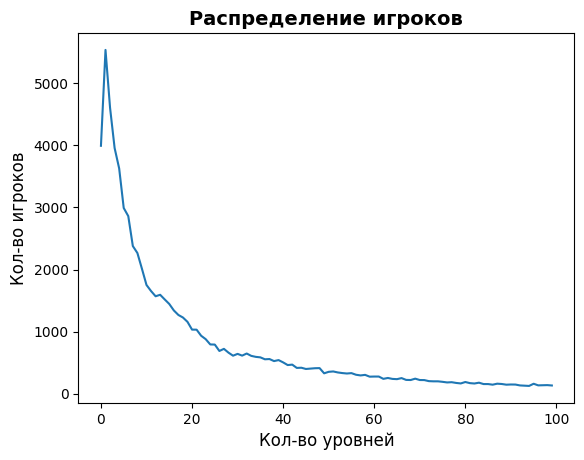

In [27]:
plot_df = df.groupby('sum_gamerounds')['userid'].count()
ax = plot_df.head(100).plot()
plt.title('Распределение игроков', fontweight='bold', size=14)
plt.xlabel('Кол-во уровней', size=12)
plt.ylabel('Кол-во игроков', size=12)
plt.show()

На графике видно некоторые игроки установив игру ни разу не играли в неё. Посчитаем их кол-во.

In [28]:
df[df['sum_gamerounds']==0]['userid'].count()

3994